In [130]:
import numpy as np
import pandas as pd

from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset

import os
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from scipy.signal import welch
from scipy.fftpack import fft

from Lilygo.Recording import Recording, data_integrity
from Lilygo.Dataset import Dataset

import joblib
from mpl_toolkits.mplot3d import Axes3D
import math


In [98]:
def get_gravity(data):
    filtered_data = np.zeros_like(data)
    # Parameters in IIR filter
    alpla = [1, -1.979133761292768, 0.979521463540373]
    beta = [0.000086384997973502, 0.00012769995947004, 0.000086384997973502]
    # Formula of IIR filter
    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data

def get_highpass(data):
    filtered_data = np.zeros_like(data)  # filtered_data
    alpla = [1, -1.905384612118461, 0.910092542787947]
    beta = [0.953986986993339, -1.907503180919730, 0.953986986993339]

    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data


def get_lowpass(data):
    filtered_data = np.zeros_like(data)  # filtered_data
    alpla = [1, -1.80898117793047, 0.827224480562408]
    beta = [0.096665967120306, -0.172688631608676, 0.095465967120306]

    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data

In [34]:
# Get the path of all traces
dir_traces = 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()
print(filenames)

['E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_001.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_002.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_003.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_004.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_005.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_006.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_007.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_008.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_009.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_010.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_011.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_012.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_013.json'

In [237]:
# Read phone accelerometer data
trace = Recording(dir_traces + 'train_trace_155.json')
ax_data = trace.data['phone_ax']
ay_data = trace.data['phone_ay']
az_data = trace.data['phone_az']
ax = np.asarray(ax_data.values)
ay = np.asarray(ay_data.values)
az = np.asarray(az_data.values)

# Read phone gyroscope data
gx = np.asarray(trace.data['phone_gx'].values)
gy = np.asarray(trace.data['phone_gy'].values)
gz = np.asarray(trace.data['phone_gz'].values)

# Get timestamps
t = ax_data.timestamps #[ms]
print(len(t))
print(t)

print(list(trace.data.keys()))

if not(trace.labels is None):
    # print("\r\nLabels: ")
    print(trace.labels)

# sampling_rate = len(timestamps)/timestamps[-1]
# print(sampling_rate)

53253
[0.00000000e+00 1.00425336e-02 2.00850672e-02 ... 5.34764915e+02
 5.34774957e+02 5.34785000e+02]
['phone_orientationy', 'phone_mz', 'longitude', 'phone_roty', 'packetNumber', 'mx', 'ay', 'phone_gravz', 'phone_lay', 'lostPackets', 'ax', 'timestamp', 'phone_rotz', 'phone_ax', 'phone_az', 'speed', 'altitude', 'phone_pressure', 'phone_gravy', 'temperature', 'my', 'mz', 'phone_rotm', 'latitude', 'az', 'gx', 'phone_lax', 'phone_rotx', 'phone_gy', 'phone_ay', 'phone_orientationx', 'bearing', 'phone_laz', 'phone_steps', 'gz', 'phone_mx', 'phone_orientationz', 'gy', 'phone_gravx', 'phone_gz', 'phone_gx', 'phone_my']
{'board_loc': 1, 'path_idx': 2, 'activities': [1]}


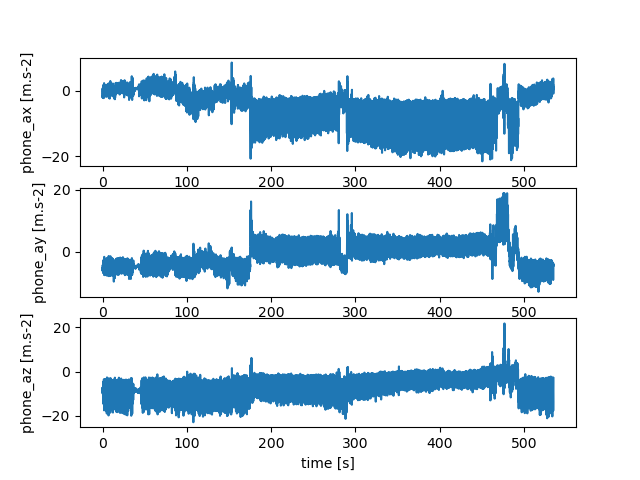

In [238]:
# Plot ---------------------------------------
plt.figure()
# x
plt.subplot(3,1,1)
plt.plot(t, ax)
plt.ylabel('phone_ax [m.s-2]')
# y
plt.subplot(3,1,2)
plt.plot(t, ay)
plt.ylabel('phone_ay [m.s-2]')
# z
plt.subplot(3,1,3)
plt.plot(t, az)
plt.ylabel('phone_az [m.s-2]')
plt.xlabel('time [s]')
plt.show()

## AHRS

In [244]:
from ahrs.filters import AQUA
acc_data = np.vstack((ax, ay, az)).T
gyro_data = np.vstack((gx, gy, gz)).T
print(np.shape(acc_data))
print(np.shape(gyro_data))
attitude = AQUA(acc=acc_data, gyr=gyro_data)
attitude.Q.shape

(53253, 3)
(53253, 3)


(53253, 4)

In [245]:
from scipy.spatial.transform import Rotation as R

# Create a Rotation object for each quaternion
rotations = R.from_quat(attitude.Q)
# Apply the rotations to the accelerometer data
acc_earth = rotations.apply(acc_data)
# Subtract gravity
print(acc_earth)
gravity = np.array([0, 0, -9.81])
acc_earth_0g = acc_earth - gravity
# print(acc_earth_0g)

[[-3.1742674  -4.75839726  7.81762077]
 [-3.82341502 -4.63904416  8.87179073]
 [-4.02619446 -4.52847449  9.64064928]
 ...
 [-4.07705876 -5.16053072 -1.23925998]
 [-3.73599485 -4.43206096 -1.27235883]
 [-3.95496864 -2.95915186 -1.24480731]]


## Integration with acc_earth_0g

0 / 53252
1 / 53252
2 / 53252
3 / 53252
4 / 53252
5 / 53252
6 / 53252
7 / 53252
8 / 53252
9 / 53252
10 / 53252
11 / 53252
12 / 53252
13 / 53252
14 / 53252
15 / 53252
16 / 53252
17 / 53252
18 / 53252
19 / 53252
20 / 53252
21 / 53252
22 / 53252
23 / 53252
24 / 53252
25 / 53252
26 / 53252
27 / 53252
28 / 53252
29 / 53252
30 / 53252
31 / 53252
32 / 53252
33 / 53252
34 / 53252
35 / 53252
36 / 53252
37 / 53252
38 / 53252
39 / 53252
40 / 53252
41 / 53252
42 / 53252
43 / 53252
44 / 53252
45 / 53252
46 / 53252
47 / 53252
48 / 53252
49 / 53252
50 / 53252
51 / 53252
52 / 53252
53 / 53252
54 / 53252
55 / 53252
56 / 53252
57 / 53252
58 / 53252
59 / 53252
60 / 53252
61 / 53252
62 / 53252
63 / 53252
64 / 53252
65 / 53252
66 / 53252
67 / 53252
68 / 53252
69 / 53252
70 / 53252
71 / 53252
72 / 53252
73 / 53252
74 / 53252
75 / 53252
76 / 53252
77 / 53252
78 / 53252
79 / 53252
80 / 53252
81 / 53252
82 / 53252
83 / 53252
84 / 53252
85 / 53252
86 / 53252
87 / 53252
88 / 53252
89 / 53252
90 / 53252
91 / 5325

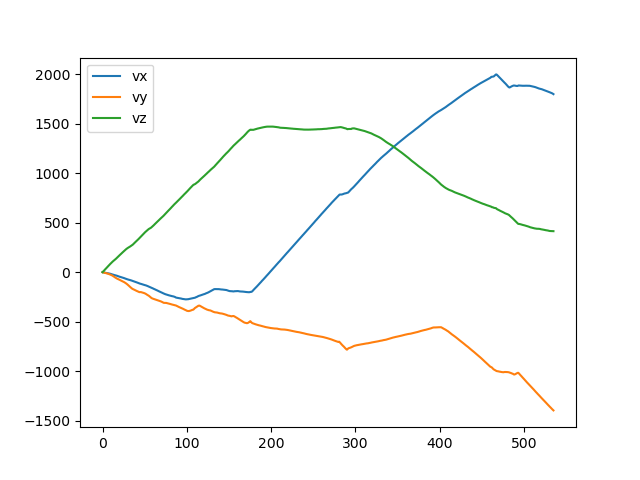

In [259]:
vx, vy, vz = np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t))
for i in range(len(t)):
    print(i, '/', len(t)-1)
    # Compute the area under the curve
    vx[i] = np.trapz(acc_earth[:i, 0], t[:i])
    vy[i] = np.trapz(acc_earth[:i, 1], t[:i])
    vz[i] = np.trapz(acc_earth[:i, 2], t[:i])

plt.figure()
plt.plot(t, vx, label='vx')
plt.plot(t, vy, label='vy')
plt.plot(t, vz, label='vz')
plt.legend()
plt.show()

0 / 53252
1 / 53252
2 / 53252
3 / 53252
4 / 53252
5 / 53252
6 / 53252
7 / 53252
8 / 53252
9 / 53252
10 / 53252
11 / 53252
12 / 53252
13 / 53252
14 / 53252
15 / 53252
16 / 53252
17 / 53252
18 / 53252
19 / 53252
20 / 53252
21 / 53252
22 / 53252
23 / 53252
24 / 53252
25 / 53252
26 / 53252
27 / 53252
28 / 53252
29 / 53252
30 / 53252
31 / 53252
32 / 53252
33 / 53252
34 / 53252
35 / 53252
36 / 53252
37 / 53252
38 / 53252
39 / 53252
40 / 53252
41 / 53252
42 / 53252
43 / 53252
44 / 53252
45 / 53252
46 / 53252
47 / 53252
48 / 53252
49 / 53252
50 / 53252
51 / 53252
52 / 53252
53 / 53252
54 / 53252
55 / 53252
56 / 53252
57 / 53252
58 / 53252
59 / 53252
60 / 53252
61 / 53252
62 / 53252
63 / 53252
64 / 53252
65 / 53252
66 / 53252
67 / 53252
68 / 53252
69 / 53252
70 / 53252
71 / 53252
72 / 53252
73 / 53252
74 / 53252
75 / 53252
76 / 53252
77 / 53252
78 / 53252
79 / 53252
80 / 53252
81 / 53252
82 / 53252
83 / 53252
84 / 53252
85 / 53252
86 / 53252
87 / 53252
88 / 53252
89 / 53252
90 / 53252
91 / 5325

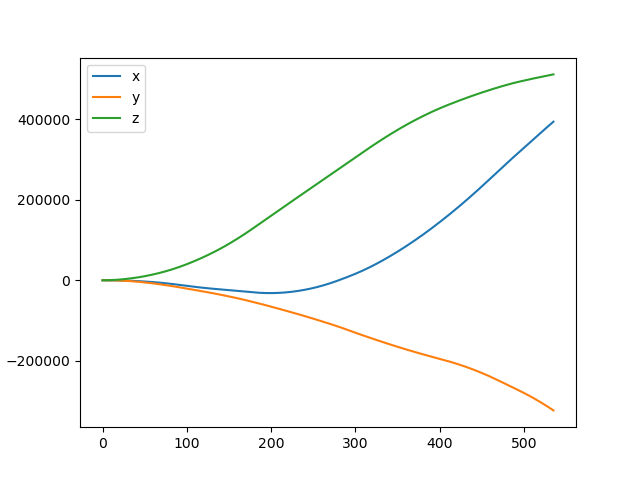

In [260]:
x, y, z = np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t))
for i in range(len(t)):
    print(i, '/', len(t)-1)
    # Compute the area under the curve
    x[i] = np.trapz(vx[:i], t[:i])
    y[i] = np.trapz(vy[:i], t[:i])
    z[i] = np.trapz(vz[:i], t[:i])

plt.figure()
plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.plot(t, z, label='z')
plt.legend()
plt.show()

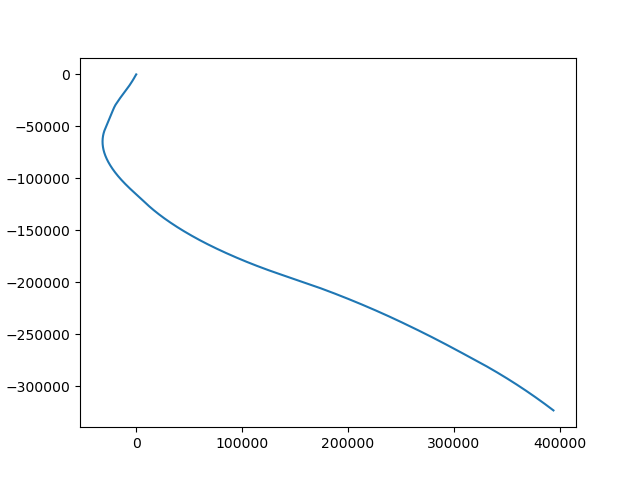

In [261]:
plt.figure()
plt.plot(x, y)
plt.show()

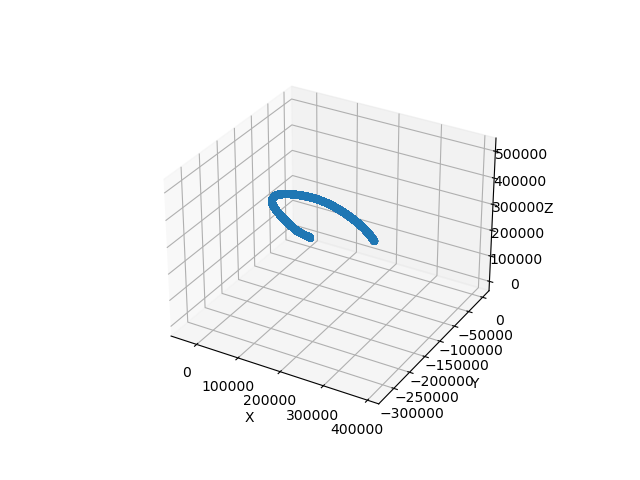

In [262]:
# index 2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

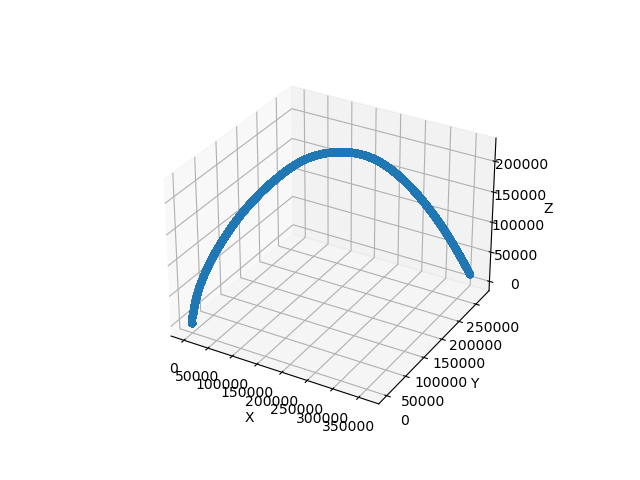

In [ ]:
# index 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

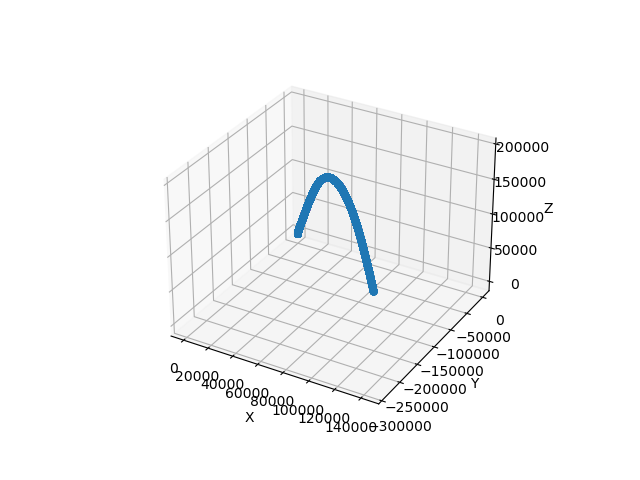

In [ ]:
# index 0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

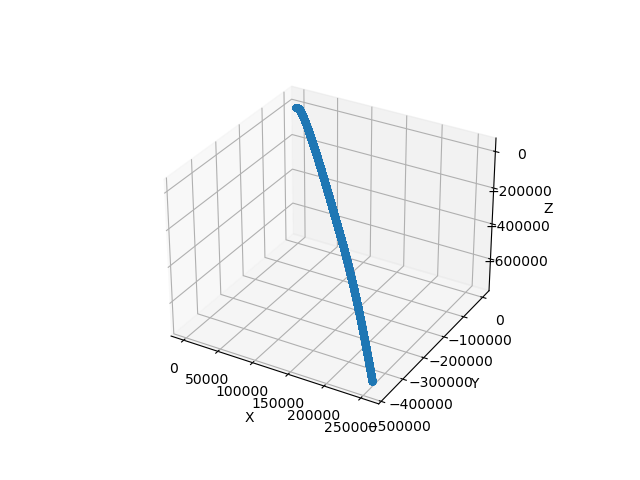

In [ ]:
# 001, index 4
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

['phone_orientationy', 'phone_mz', 'longitude', 'phone_roty', 'packetNumber', 'mx', 'ay', 'phone_gravz', 'phone_lay', 'lostPackets', 'ax', 'timestamp', 'phone_rotz', 'phone_ax', 'phone_az', 'speed', 'altitude', 'phone_pressure', 'phone_gravy', 'temperature', 'my', 'mz', 'phone_rotm', 'latitude', 'az', 'gx', 'phone_lax', 'phone_rotx', 'phone_gy', 'phone_ay', 'phone_orientationx', 'bearing', 'phone_laz', 'phone_steps', 'gz', 'phone_mx', 'phone_orientationz', 'gy', 'phone_gravx', 'phone_gz', 'phone_gx', 'phone_my']
{'board_loc': 0, 'path_idx': 0, 'activities': [1, 2, 1]}


## Remove gravity

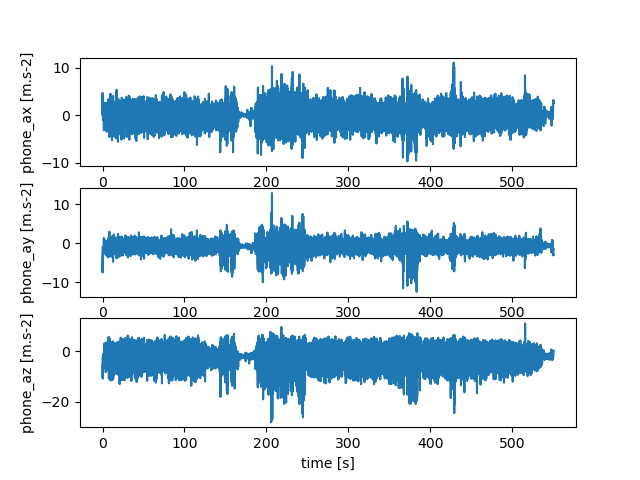

In [150]:
ax_0g = ax - get_gravity(ax)
ay_0g = ay - get_gravity(ay)
az_0g = az - get_gravity(az)

# Plot ---------------------------------------
plt.figure()
# x
plt.subplot(3,1,1)
plt.plot(t, ax_0g)
plt.ylabel('phone_ax [m.s-2]')
# y
plt.subplot(3,1,2)
plt.plot(t, ay_0g)
plt.ylabel('phone_ay [m.s-2]')
# z
plt.subplot(3,1,3)
plt.plot(t, az_0g)
plt.ylabel('phone_az [m.s-2]')
plt.xlabel('time [s]')
plt.show()

## Integration to get velocity and acceleration

In [149]:
vx, vy, vz = np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t))
for i in range(len(t)):
    print(i, '/', len(t)-1)
    # Compute the area under the curve
    vx[i] = np.trapz(ax_0g[:i], t[:i])
    vy[i] = np.trapz(ay_0g[:i], t[:i])
    vz[i] = np.trapz(az_0g[:i], t[:i])

0 / 55488
1 / 55488
2 / 55488
3 / 55488
4 / 55488
5 / 55488
6 / 55488
7 / 55488
8 / 55488
9 / 55488
10 / 55488
11 / 55488
12 / 55488
13 / 55488
14 / 55488
15 / 55488
16 / 55488
17 / 55488
18 / 55488
19 / 55488
20 / 55488
21 / 55488
22 / 55488
23 / 55488
24 / 55488
25 / 55488
26 / 55488
27 / 55488
28 / 55488
29 / 55488
30 / 55488
31 / 55488
32 / 55488
33 / 55488
34 / 55488
35 / 55488
36 / 55488
37 / 55488
38 / 55488
39 / 55488
40 / 55488
41 / 55488
42 / 55488
43 / 55488
44 / 55488
45 / 55488
46 / 55488
47 / 55488
48 / 55488
49 / 55488
50 / 55488
51 / 55488
52 / 55488
53 / 55488
54 / 55488
55 / 55488
56 / 55488
57 / 55488
58 / 55488
59 / 55488
60 / 55488
61 / 55488
62 / 55488
63 / 55488
64 / 55488
65 / 55488
66 / 55488
67 / 55488
68 / 55488
69 / 55488
70 / 55488
71 / 55488
72 / 55488
73 / 55488
74 / 55488
75 / 55488
76 / 55488
77 / 55488
78 / 55488
79 / 55488
80 / 55488
81 / 55488
82 / 55488
83 / 55488
84 / 55488
85 / 55488
86 / 55488
87 / 55488
88 / 55488
89 / 55488
90 / 55488
91 / 5548

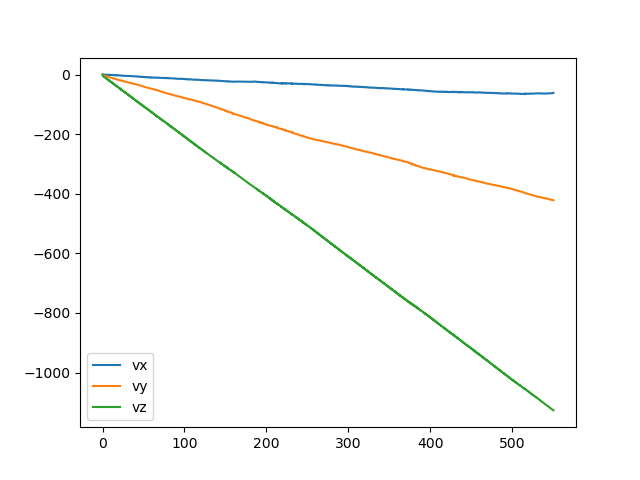

In [151]:
plt.figure()
plt.plot(t, vx, label='vx')
plt.plot(t, vy, label='vy')
plt.plot(t, vz, label='vz')
plt.legend()
plt.show()

In [122]:
# Integration
dt = t[1] - t[0]
vx, vy, vz = [0], [0], [0]

for i in range(len(t)-1):
    print(i, '/', len(t)-1)
    vx = vx + [vx[-1] + ax[i]*dt]
    vy = vy + [vy[-1] + ay[i]*dt]
    vz = vz + [vz[-1] + az[i]*dt]

0 / 55488
1 / 55488
2 / 55488
3 / 55488
4 / 55488
5 / 55488
6 / 55488
7 / 55488
8 / 55488
9 / 55488
10 / 55488
11 / 55488
12 / 55488
13 / 55488
14 / 55488
15 / 55488
16 / 55488
17 / 55488
18 / 55488
19 / 55488
20 / 55488
21 / 55488
22 / 55488
23 / 55488
24 / 55488
25 / 55488
26 / 55488
27 / 55488
28 / 55488
29 / 55488
30 / 55488
31 / 55488
32 / 55488
33 / 55488
34 / 55488
35 / 55488
36 / 55488
37 / 55488
38 / 55488
39 / 55488
40 / 55488
41 / 55488
42 / 55488
43 / 55488
44 / 55488
45 / 55488
46 / 55488
47 / 55488
48 / 55488
49 / 55488
50 / 55488
51 / 55488
52 / 55488
53 / 55488
54 / 55488
55 / 55488
56 / 55488
57 / 55488
58 / 55488
59 / 55488
60 / 55488
61 / 55488
62 / 55488
63 / 55488
64 / 55488
65 / 55488
66 / 55488
67 / 55488
68 / 55488
69 / 55488
70 / 55488
71 / 55488
72 / 55488
73 / 55488
74 / 55488
75 / 55488
76 / 55488
77 / 55488
78 / 55488
79 / 55488
80 / 55488
81 / 55488
82 / 55488
83 / 55488
84 / 55488
85 / 55488
86 / 55488
87 / 55488
88 / 55488
89 / 55488
90 / 55488
91 / 5548

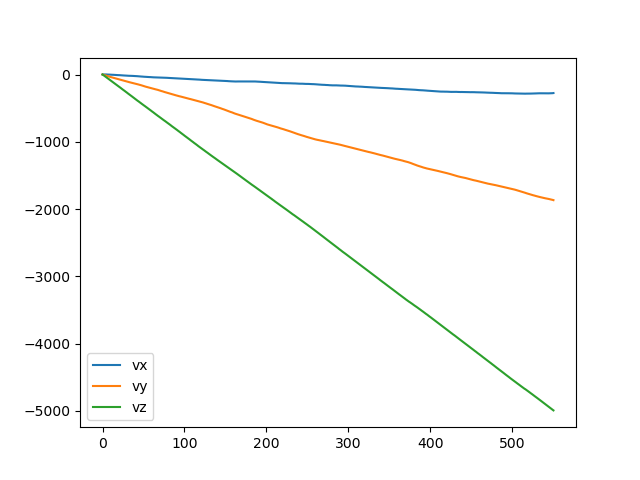

In [123]:
plt.figure()
plt.plot(t, vx, label='vx')
plt.plot(t, vy, label='vy')
plt.plot(t, vz, label='vz')
plt.legend()
plt.show()

In [124]:
x, y, z = [0], [0], [0]

for i in range(len(t)-1):
    print(i, '/', len(t)-1)
    x = x + [x[-1] + vx[i]*dt]
    y = y + [y[-1] + vy[i]*dt]
    z = z + [z[-1] + vz[i]*dt]
    


0 / 55488
1 / 55488
2 / 55488
3 / 55488
4 / 55488
5 / 55488
6 / 55488
7 / 55488
8 / 55488
9 / 55488
10 / 55488
11 / 55488
12 / 55488
13 / 55488
14 / 55488
15 / 55488
16 / 55488
17 / 55488
18 / 55488
19 / 55488
20 / 55488
21 / 55488
22 / 55488
23 / 55488
24 / 55488
25 / 55488
26 / 55488
27 / 55488
28 / 55488
29 / 55488
30 / 55488
31 / 55488
32 / 55488
33 / 55488
34 / 55488
35 / 55488
36 / 55488
37 / 55488
38 / 55488
39 / 55488
40 / 55488
41 / 55488
42 / 55488
43 / 55488
44 / 55488
45 / 55488
46 / 55488
47 / 55488
48 / 55488
49 / 55488
50 / 55488
51 / 55488
52 / 55488
53 / 55488
54 / 55488
55 / 55488
56 / 55488
57 / 55488
58 / 55488
59 / 55488
60 / 55488
61 / 55488
62 / 55488
63 / 55488
64 / 55488
65 / 55488
66 / 55488
67 / 55488
68 / 55488
69 / 55488
70 / 55488
71 / 55488
72 / 55488
73 / 55488
74 / 55488
75 / 55488
76 / 55488
77 / 55488
78 / 55488
79 / 55488
80 / 55488
81 / 55488
82 / 55488
83 / 55488
84 / 55488
85 / 55488
86 / 55488
87 / 55488
88 / 55488
89 / 55488
90 / 55488
91 / 5548

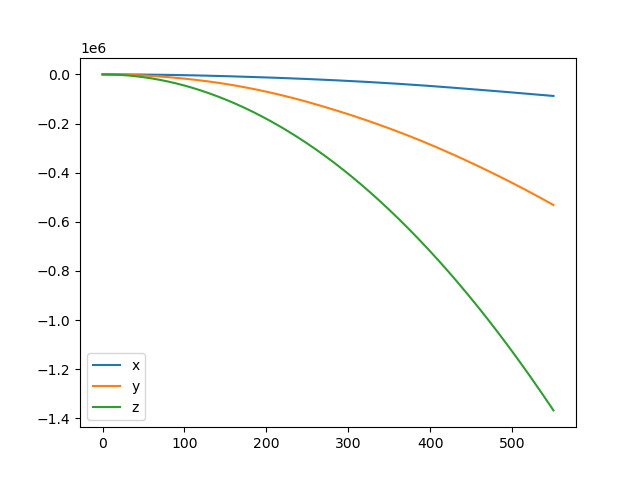

In [125]:
plt.figure()
plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.plot(t, z, label='z')
plt.legend()
plt.show()

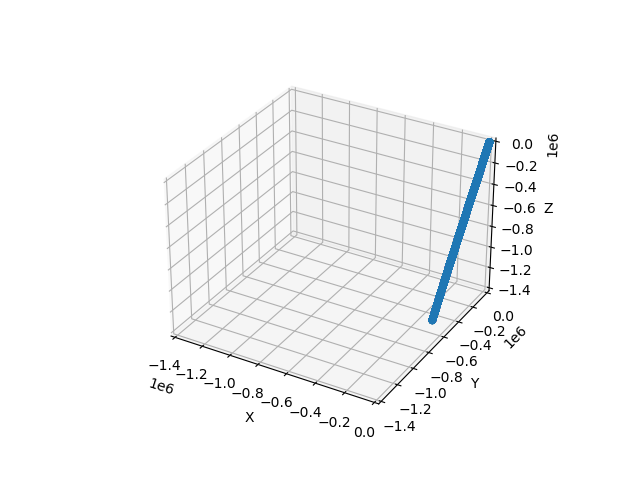

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits for each axis
ax.set_xlim([-1400000, 0])
ax.set_ylim([-1400000, 0])
ax.set_zlim([-1400000, 0])

plt.show()